In [27]:
import numpy as np
from utils import load_surf, load_config, butterworth_highpass, zscore, load_mp3, get_envelope, lanczosinterp2D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.signal import clean
import nibabel as nib
import os

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']

subjects = ['sub-UTS02', 'sub-001', 'sub-003', 'sub-004']
story = 'treasureisland'

tr = 1.5

from nilearn import plotting, datasets

# fig, axes = plt.subplots(4, 4, figsize=(20, 15), subplot_kw={'projection': '3d'})

# grid = plt.GridSpec(4, 4)

# for irow, title in enumerate(['ISC', f'Corr env {subjects[0]}', f'Corr env {subjects[1]}', f'Corr env {subjects[2]}']):
#     row = fig.add_subplot(grid[irow, :])
#     row.set_title(title)
#     # hide subplot
#     row.axis('off')
#     row.set_frame_on(False)

# auditory envelope
audio, sr = load_mp3(STIMDIR, story)
audio_envelope = get_envelope(audio)
story_length = len(audio) / sr # in seconds

# average envelope every 0.1 seconds
window = 0.1
audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * window) * int(sr * window)].reshape(-1, int(sr * window)), axis=1).reshape(-1, 1)

zEnv = zscore(lanczosinterp2D(audio_envelope_avg, np.arange(audio_envelope_avg.shape[0]) * window, np.arange(13.5 // tr, story_length // tr) * tr), axis=0)

n_trs = zEnv.shape[0]

for hemi in ['L']:
    if hemi == 'L':
        cols = [0, 1]
        hemi_str = 'left'
    else:
        cols = [2, 3]
        hemi_str = 'right'

    surf_data_all = []
    for subject in subjects:
        surf_data = load_surf(DATADIR, subject, story, hemi)
        if subject[4:7] == 'UTS':
            tr_len = 2
        else:
            tr_len = 1.5
        surf_data = zscore(butterworth_highpass(surf_data, tr_len, 0.01), axis=1)
        if subject[4:7] == 'UTS':
            surf_data = surf_data[:, 5:] # trim the first 5 TRs to align with story start
            # resample to 1.5s TR
            surf_data = lanczosinterp2D(surf_data.T, np.arange(surf_data.shape[1]) * tr_len, np.arange(n_trs) * tr).T
        elif subject == 'sub-001':
            if story == 'odetostepfather': # trim the first 9 TRs of music
                surf_data = surf_data[:, 9:n_trs+9]
            else:
                surf_data = surf_data[:, 19:n_trs+19] # trim the first (10 + 9) TRs of wait period + music
        else:
            surf_data = surf_data[:, 17:n_trs+17] # trim the first (8 + 9) TRs of wait period + music
        surf_data_all.append(surf_data)

    surf_data_all = np.array(surf_data_all)
    
    n_voxels = surf_data_all.shape[1]

    # # Calculate the inter-subject correlation between BOLD responses and the correlation between BOLD signal and audio envelope for each voxel
    # iscs_all = np.zeros((n_voxels, len(subjects) * (len(subjects) - 1) // 2))
    # for ivoxel in range(n_voxels):
    #     surf_data_subject = np.squeeze(surf_data_all[:, ivoxel, :])
    #     isc_mat = np.corrcoef(surf_data_subject)
    #     iscs_voxel = [isc_mat[i, j] for i in range(len(subjects)) for j in range(i + 1, len(subjects))]
    #     iscs_all[ivoxel] = iscs_voxel

    # # sort the roi_corrs_all and print isc for each roi in descending order
    # iscs = np.mean(iscs_all, axis=1)

    # fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')
    # annot_file = f'/Users/gio/Downloads/{hemi.lower()}h.Schaefer2018_200Parcels_17Networks_order.annot'
    # surf_labels, ctab, surf_names = nib.freesurfer.read_annot(annot_file)
    # surf_labels = surf_labels.astype(int)
    # surf_names = [name.decode('utf-8') for name in surf_names]

    # # plot isc
    # if hemi == 'L':
    #     f_isc_l = plotting.plot_surf_stat_map(fsaverage.infl_left, iscs, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, axes=axes[0, cols[0]])
    #     f_isc_m = plotting.plot_surf_stat_map(fsaverage.infl_left, iscs, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, view='medial', axes=axes[0, cols[1]])
    # else:
    #     f_isc_l = plotting.plot_surf_stat_map(fsaverage.infl_right, iscs, hemi='right', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, axes=axes[0, cols[0]])
    #     f_isc_m = plotting.plot_surf_stat_map(fsaverage.infl_right, iscs, hemi='right', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, view='medial', axes=axes[0, cols[1]])

    # # plot correlation between BOLD signal and audio envelope
    # for isubj in range(len(subjects)):
    #     if hemi == 'L':
    #         f_corr_l = plotting.plot_surf_stat_map(fsaverage.infl_left, corr_env_all[isubj], hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, axes=axes[isubj + 1, cols[0]])
    #         f_corr_m = plotting.plot_surf_stat_map(fsaverage.infl_left, corr_env_all[isubj], hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, view='medial', axes=axes[isubj + 1, cols[1]])
    #     else:
    #         f_corr_l = plotting.plot_surf_stat_map(fsaverage.infl_right, corr_env_all[isubj], hemi='right', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, axes=axes[isubj + 1, cols[0]])
    #         f_corr_m = plotting.plot_surf_stat_map(fsaverage.infl_right, corr_env_all[isubj], hemi='right', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, view='medial', axes=axes[isubj + 1, cols[1]])


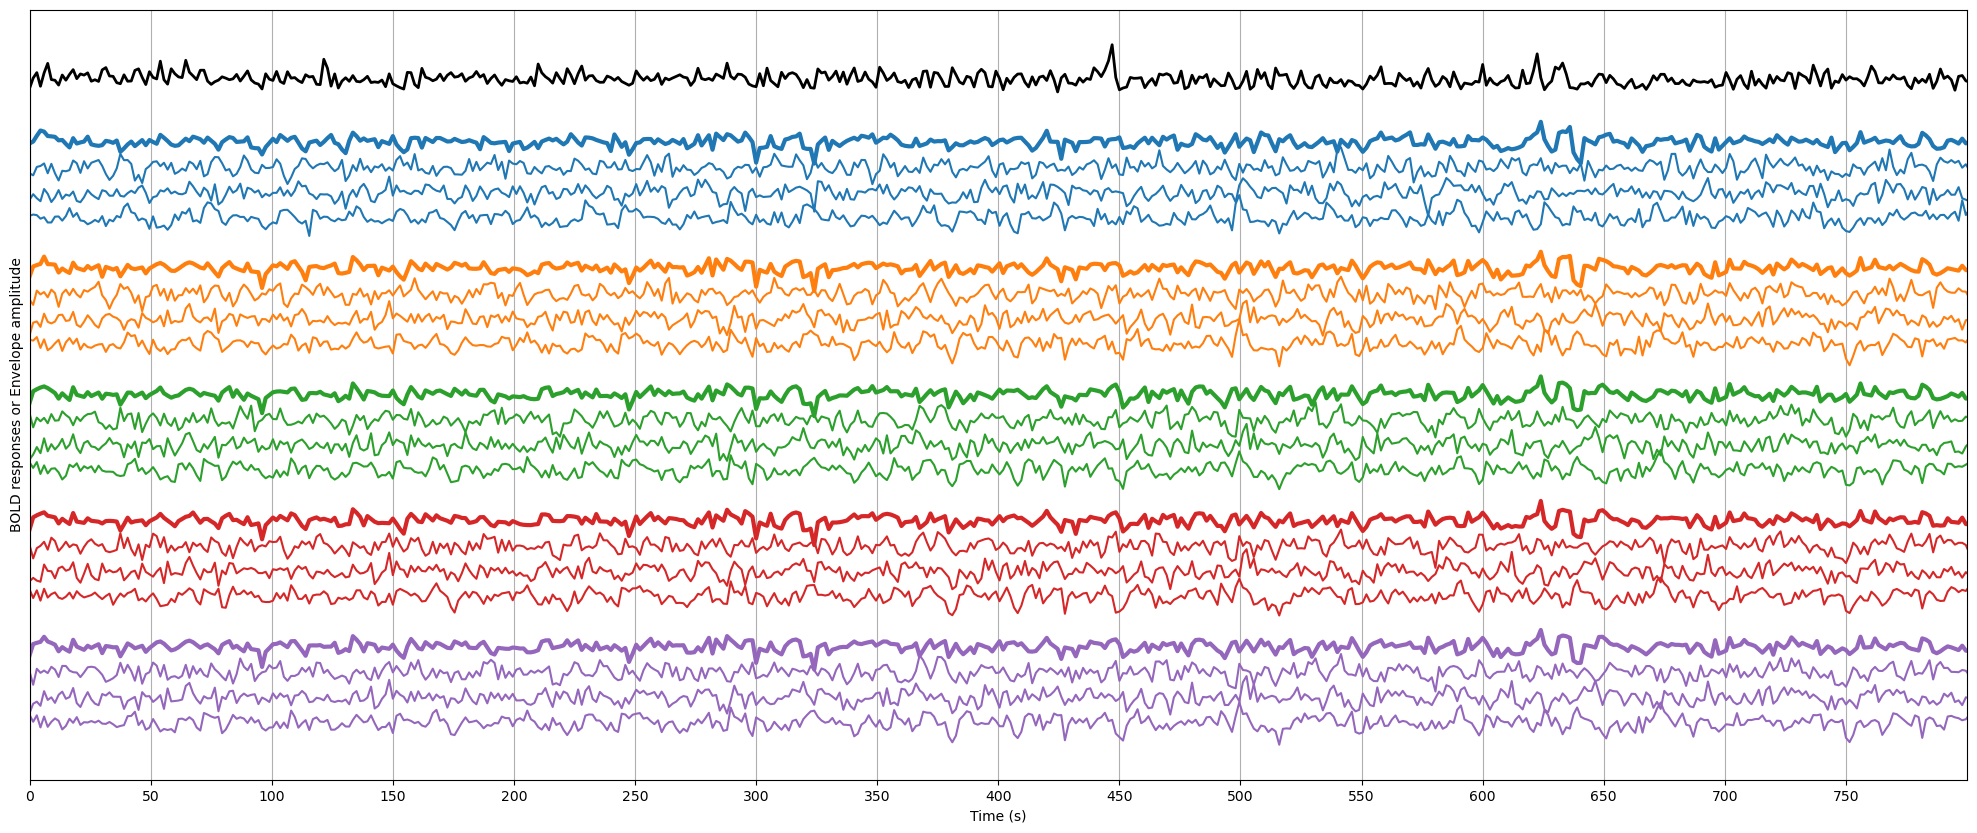

In [28]:
from matplotlib.pyplot import figure
selvoxels = [1663, 16953, 11411, 3732, 25149]

colors = plt.cm.tab10.colors
f = figure(figsize=(25,10))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(np.arange(zEnv.shape[0]) * tr, zEnv + 10, "k-", linewidth=2, label="Downsampled envelope (TR)")
for i, voxel in enumerate(selvoxels):
    for isubject in range(len(subjects)):
        if isubject == 0:
            ax.plot(np.arange(n_trs) * tr, surf_data_all[isubject, voxel, :].flatten() - 20 * i - 4 * isubject, linewidth=3, label=f"Voxel {voxel}", color=colors[i])
        else:
            ax.plot(np.arange(n_trs) * tr, surf_data_all[isubject, voxel, :].flatten() - 20 * i - 4 * isubject, label=f"Voxel {voxel}", color=colors[i])


ax.set_xlim(0, 800)
ax.set_xticks(range(0, 800, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()

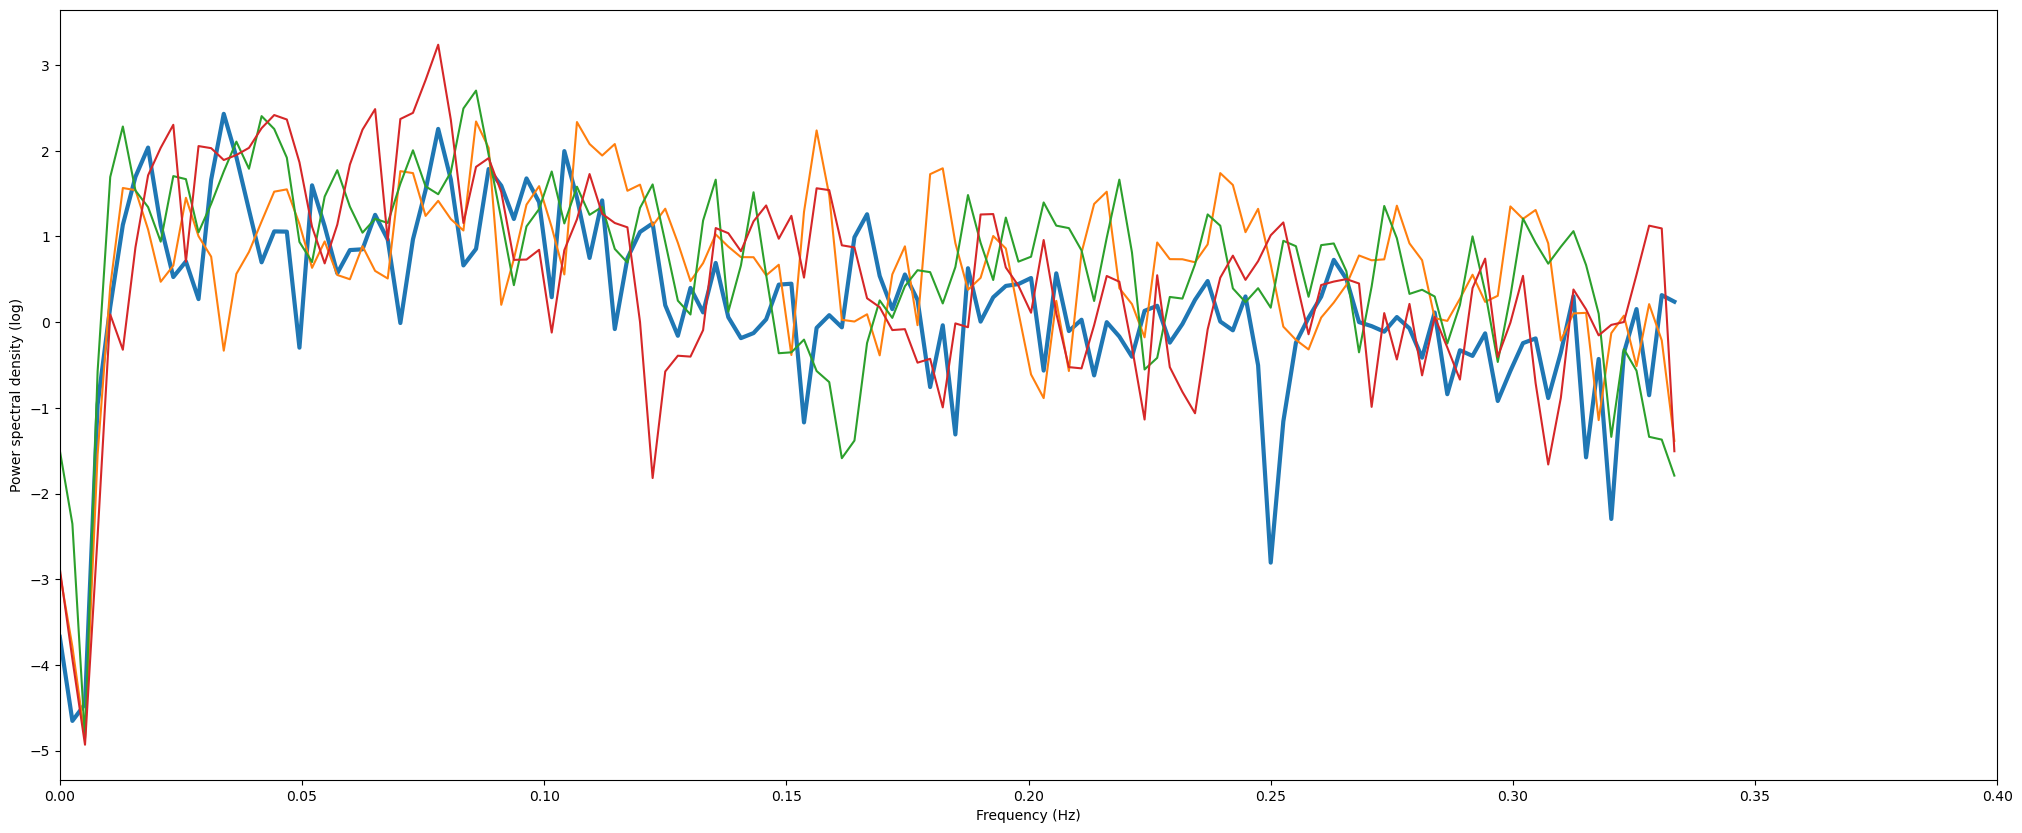

In [29]:
# welch power spectrum
from scipy.signal import welch
f_welch = figure(figsize=(25,10))
f_welch.clf()
ax = f_welch.add_subplot(1,1,1)
for isubject in range(len(subjects)):
    f, Pxx = welch(surf_data_all[isubject, selvoxels[0], :].flatten(), fs=1/tr, nperseg=256)
    if isubject == 0:
        ax.plot(f, np.log(Pxx), color=colors[isubject], linewidth=3)
    else:
        ax.plot(f, np.log(Pxx), color=colors[isubject], label=f"Subject {isubject}")
    ax.set_xlim(0, .4)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power spectral density (log)")


In [30]:
# Calculate the inter-subject correlation between BOLD responses and the correlation between BOLD signal and audio envelope for each voxel
iscs_all = np.zeros((n_voxels, len(subjects) * (len(subjects) - 1) // 2))
for ivoxel in range(n_voxels):
    surf_data_subject = np.squeeze(surf_data_all[:, ivoxel, :])
    isc_mat = np.corrcoef(surf_data_subject)
    iscs_voxel = [isc_mat[i, j] for i in range(len(subjects)) for j in range(i + 1, len(subjects))]
    iscs_all[ivoxel] = iscs_voxel

isc_mean = np.mean(iscs_all, axis=1)
isc_huth = np.mean(iscs_all[:, :3], axis=1)
isc_mine = np.mean(iscs_all[:, 3:], axis=1)

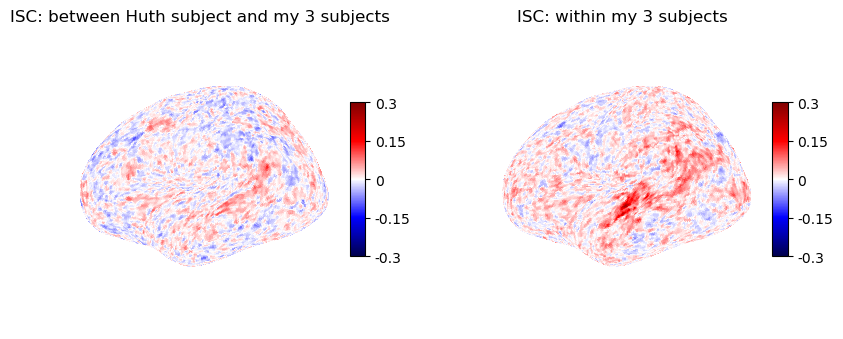

In [31]:
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')
# annot_file = f'/Users/gio/Downloads/{hemi.lower()}h.Schaefer2018_200Parcels_17Networks_order.annot'
# surf_labels, ctab, surf_names = nib.freesurfer.read_annot(annot_file)
# surf_labels = surf_labels.astype(int)
# surf_names = [name.decode('utf-8') for name in surf_names]
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

# plot isc
if hemi == 'L':
    # f_isc_l = plotting.plot_surf_stat_map(fsaverage.infl_left, isc_mean, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3) #, axes=axes[0, cols[0]])
    f_isc_l_huth = plotting.plot_surf_stat_map(fsaverage.infl_left, isc_huth, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, title='ISC: between Huth subject and my 3 subjects', axes=axes[0])
    f_isc_l_mine = plotting.plot_surf_stat_map(fsaverage.infl_left, isc_mine, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, title='ISC: within my 3 subjects', axes=axes[1])

    # f_isc_l = plotting.plot_surf_stat_map(fsaverage.infl_left, iscs_all[:, 2], hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3) #, axes=axes[0, cols[0])

    # f_isc_m = plotting.plot_surf_stat_map(fsaverage.infl_left, iscs, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, view='medial', axes=axes[0, cols[1]])

(-0.5, 0.5)

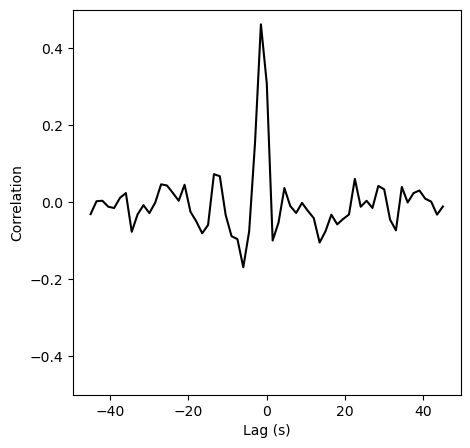

In [32]:
selvoxels = [1663, 16953, 11411, 11410, 3732, 25149, 269, 11412, 27369, 25150]

# compute lag cross correlation between two time series
from scipy.signal import correlate
from scipy.stats import zscore

def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

lags, corrs = lagcorr(zEnv.flatten(), surf_data_all[0, selvoxels[2], :].flatten(), maxlag=30)

f = figure(figsize=(5,5))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(lags * tr, corrs, "k-")
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")
ax.set_ylim(-0.5, 0.5)

In [39]:
# build with audio envelope
from utils import make_delayed, pearsonr
from ridge import ridge_cv

n_delays = 5 # 7.5 seconds
xdata = make_delayed(zEnv, np.arange(1, n_delays + 1))

nfolds = 5

alphas = np.logspace(-3, 3, 7)

wt, corr, alphas, bscorrs, valinds, voxcorrs = ridge_cv(xdata, np.squeeze(surf_data_all[3, :, :]).T, alphas, nfolds)

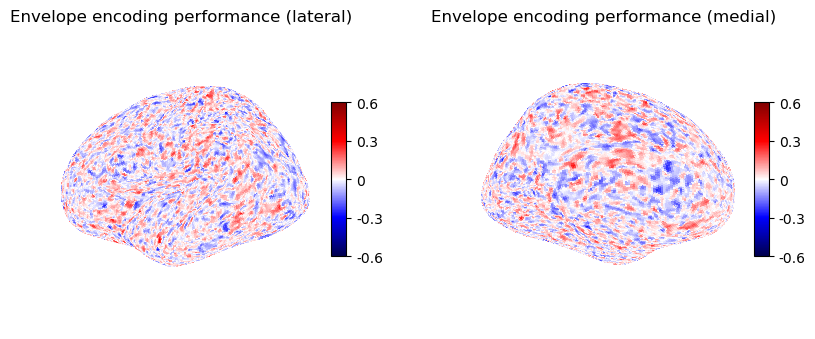

In [40]:
# # Plot histogram of correlations
# sorted_voxels = np.argsort(voxcorrs)[::-1]
# print(sorted_voxels[:10])
# print(sorted_voxels[10:20])
# f = figure(figsize=(3,3))
# ax = f.add_subplot(1,1,1)
# ax.hist(voxcorrs, 100) # histogram correlations with 100 bins
# ax.set_xlabel("Correlation")
# ax.set_ylabel("Num. voxels")

# plot surface map

fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage6")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

fig_l = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.6, vmin=-0.6, axes=axes[0], title='Envelope encoding performance (lateral)')

fig_m = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.6, vmin=-0.6, axes=axes[1], title='Envelope encoding performance (medial)')

In [35]:
# Another story
import numpy as np
from utils import load_surf, load_config, butterworth_highpass, zscore, load_mp3, get_envelope, lanczosinterp2D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.signal import clean
import nibabel as nib
import os

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']

subjects = ['sub-UTS02', 'sub-001', 'sub-003', 'sub-004']
story = 'swimming'

tr = 1.5

from nilearn import plotting, datasets

# fig, axes = plt.subplots(4, 4, figsize=(20, 15), subplot_kw={'projection': '3d'})

# grid = plt.GridSpec(4, 4)

# for irow, title in enumerate(['ISC', f'Corr env {subjects[0]}', f'Corr env {subjects[1]}', f'Corr env {subjects[2]}']):
#     row = fig.add_subplot(grid[irow, :])
#     row.set_title(title)
#     # hide subplot
#     row.axis('off')
#     row.set_frame_on(False)

# auditory envelope
audio, sr = load_mp3(STIMDIR, story)
audio_envelope = get_envelope(audio)
story_length = len(audio) / sr # in seconds

# average envelope every 0.1 seconds
window = 0.1
audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * window) * int(sr * window)].reshape(-1, int(sr * window)), axis=1).reshape(-1, 1)

zEnv = zscore(lanczosinterp2D(audio_envelope_avg, np.arange(audio_envelope_avg.shape[0]) * window, np.arange(13.5 // tr, story_length // tr) * tr), axis=0)

n_trs = zEnv.shape[0]

for hemi in ['L']:
    if hemi == 'L':
        cols = [0, 1]
        hemi_str = 'left'
    else:
        cols = [2, 3]
        hemi_str = 'right'

    surf_data_all = []
    for subject in subjects:
        surf_data = load_surf(DATADIR, subject, story, hemi)
        if subject[4:7] == 'UTS':
            tr_len = 2
        else:
            tr_len = 1.5
        surf_data = zscore(butterworth_highpass(surf_data, tr_len, 0.01), axis=1)
        if subject[4:7] == 'UTS':
            surf_data = surf_data[:, 5:] # trim the first 5 TRs to align with story start
            # resample to 1.5s TR
            surf_data = lanczosinterp2D(surf_data.T, np.arange(surf_data.shape[1]) * tr_len, np.arange(n_trs) * tr).T
        elif subject == 'sub-001':
            if story == 'odetostepfather': # trim the first 9 TRs of music
                surf_data = surf_data[:, 9:n_trs+9]
            else:
                surf_data = surf_data[:, 19:n_trs+19] # trim the first (10 + 9) TRs of wait period + music
        else:
            surf_data = surf_data[:, 17:n_trs+17] # trim the first (8 + 9) TRs of wait period + music
        surf_data_all.append(surf_data)

    surf_data_all = np.array(surf_data_all)
    
    n_voxels = surf_data_all.shape[1]

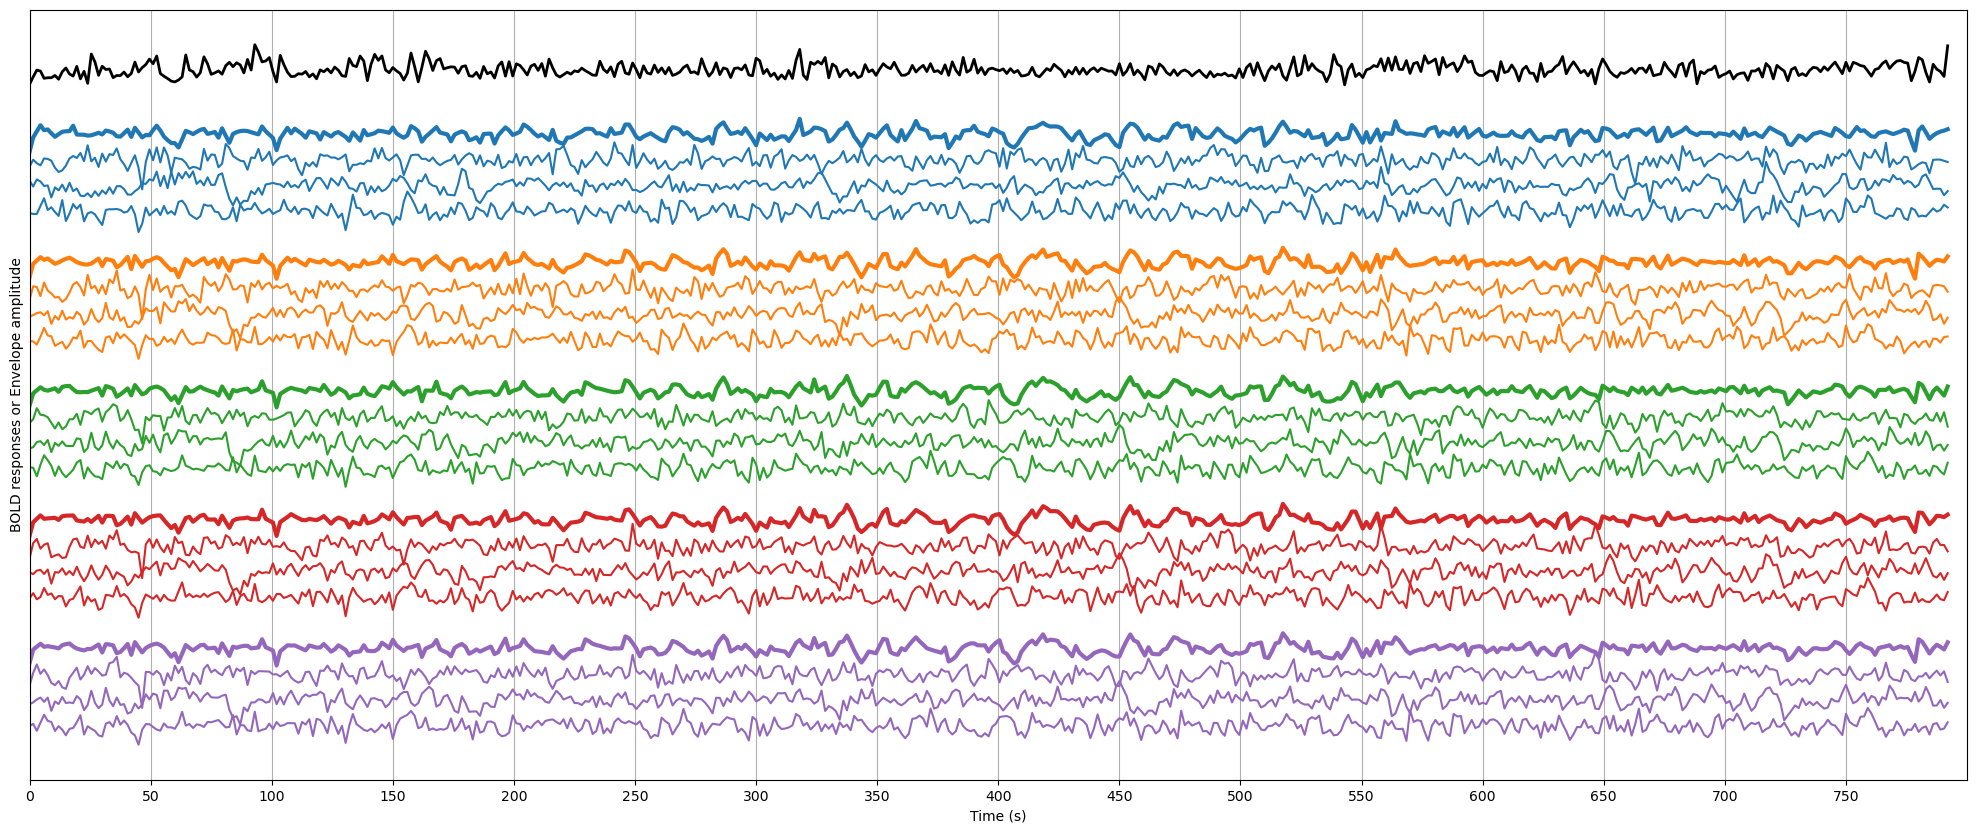

In [36]:
from matplotlib.pyplot import figure
selvoxels = [1663, 16953, 11411, 3732, 25149]

colors = plt.cm.tab10.colors
f = figure(figsize=(25,10))
f.clf()
ax = f.add_subplot(1,1,1)
ax.plot(np.arange(zEnv.shape[0]) * tr, zEnv + 10, "k-", linewidth=2, label="Downsampled envelope (TR)")
for i, voxel in enumerate(selvoxels):
    for isubject in range(len(subjects)):
        if isubject == 0:
            ax.plot(np.arange(n_trs) * tr, surf_data_all[isubject, voxel, :].flatten() - 20 * i - 4 * isubject, linewidth=3, label=f"Voxel {voxel}", color=colors[i])
        else:
            ax.plot(np.arange(n_trs) * tr, surf_data_all[isubject, voxel, :].flatten() - 20 * i - 4 * isubject, label=f"Voxel {voxel}", color=colors[i])


ax.set_xlim(0, 800)
ax.set_xticks(range(0, 800, 50))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD responses or Envelope amplitude")
ax.grid()

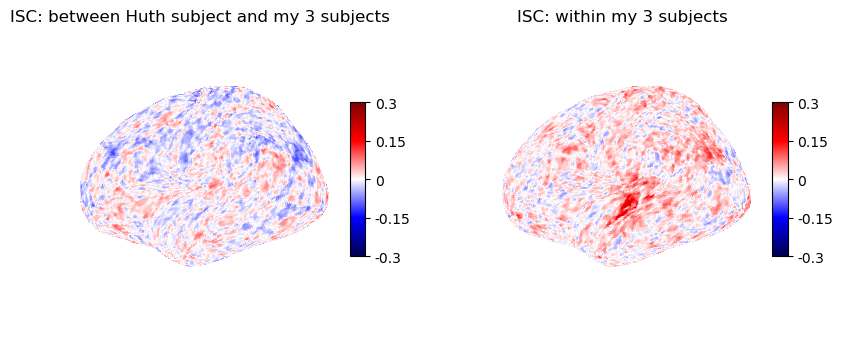

In [37]:
# ISC
# Calculate the inter-subject correlation between BOLD responses and the correlation between BOLD signal and audio envelope for each voxel
iscs_all = np.zeros((n_voxels, len(subjects) * (len(subjects) - 1) // 2))
for ivoxel in range(n_voxels):
    surf_data_subject = np.squeeze(surf_data_all[:, ivoxel, :])
    isc_mat = np.corrcoef(surf_data_subject)
    iscs_voxel = [isc_mat[i, j] for i in range(len(subjects)) for j in range(i + 1, len(subjects))]
    iscs_all[ivoxel] = iscs_voxel

isc_mean = np.mean(iscs_all, axis=1)
isc_huth = np.mean(iscs_all[:, :3], axis=1)
isc_mine = np.mean(iscs_all[:, 3:], axis=1)

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')
# annot_file = f'/Users/gio/Downloads/{hemi.lower()}h.Schaefer2018_200Parcels_17Networks_order.annot'
# surf_labels, ctab, surf_names = nib.freesurfer.read_annot(annot_file)
# surf_labels = surf_labels.astype(int)
# surf_names = [name.decode('utf-8') for name in surf_names]
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

# plot isc
if hemi == 'L':
    # f_isc_l = plotting.plot_surf_stat_map(fsaverage.infl_left, isc_mean, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3) #, axes=axes[0, cols[0]])
    f_isc_l_huth = plotting.plot_surf_stat_map(fsaverage.infl_left, isc_huth, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, title='ISC: between Huth subject and my 3 subjects', axes=axes[0])
    f_isc_l_mine = plotting.plot_surf_stat_map(fsaverage.infl_left, isc_mine, hemi='left', colorbar=True, cmap='seismic', vmax=0.3, vmin=-0.3, title='ISC: within my 3 subjects', axes=axes[1])

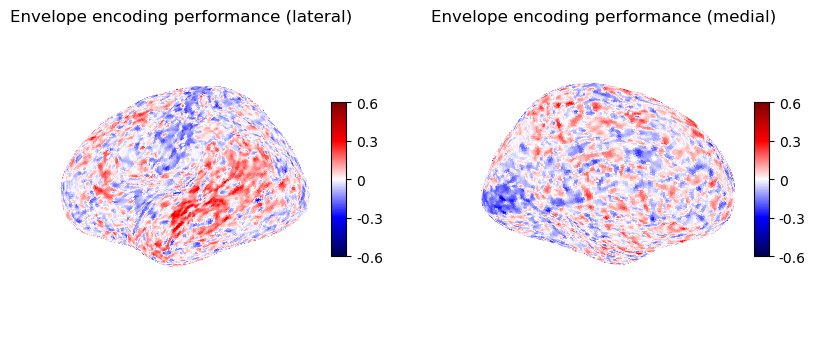

In [38]:
# envelope encoding model
from utils import make_delayed, pearsonr
from ridge import ridge_cv

n_delays = 5 # 7.5 seconds
xdata = make_delayed(zEnv, np.arange(1, n_delays + 1))

nfolds = 5

alphas = np.logspace(-3, 3, 7)

wt, corr, alphas, bscorrs, valinds, voxcorrs = ridge_cv(xdata, np.squeeze(surf_data_all[0, :, :]).T, alphas, nfolds)

# plot surface map

fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage6")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

fig_l = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.6, vmin=-0.6, axes=axes[0], title='Envelope encoding performance (lateral)')

fig_m = plotting.plot_surf_stat_map(fsaverage.infl_left, voxcorrs, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.6, vmin=-0.6, axes=axes[1], title='Envelope encoding performance (medial)')